---
title: "Diffusion models"
author: "Louie John M. Rubio"

bibliography: diff_notes.bib
csl: ieee.csl

numbersections: true

format:
    html:
        code-fold: true
        embed-resoures: true
        self-contained: true

jupyter: python3
toc: true
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Notes for Physics 312 class readings

## General overview/ideas

Diffusion models are also a type of neural network (like large language models). However, compared to large language models, they serve a completely different purpose. Diffusion models are more known to the public as AI image generators.  I personally first encountered OpenAI's own image generation system called DALL-E 2, which is a specific model that generates images from text prompts.

Look at```“A Shiba Inu dog wearing a beret and black turtleneck"```, which I generated using DALL-E 2 around late 2022.

![An image generate with DALL-E 2 using the prompt “A Shiba Inu dog wearing a beret and black turtleneck](dalle_dog.png){width=60% #fig-dog}


We'll first look at a general overview of ideas shown in Anil Ananthaswamy's post in Quanta Magazine: "The Physics Principle That Inspired Modern AI Art" [@quantamag].

1) Generative models

* The goal of generative models is to learn a probability distribution for a set of images and generate a new data points that follow the original.

* Earlier models that produce realistic image include generative adversarial networks (GAN). However, they are hard to train.

2) Probability distributions

The post motivated how creating data from images works.

* For a 2 pixel image case - each pixel can be described by a number from 0 to 255.  Each pixel is a dimension -- thus you can plot this image as a point in 2D space.

The plot below shows a visual example for 3 2-pixel images, and plotting them in 2D space.

Text(0.5, 1.0, 'Three 2 pixel images in 2D space')

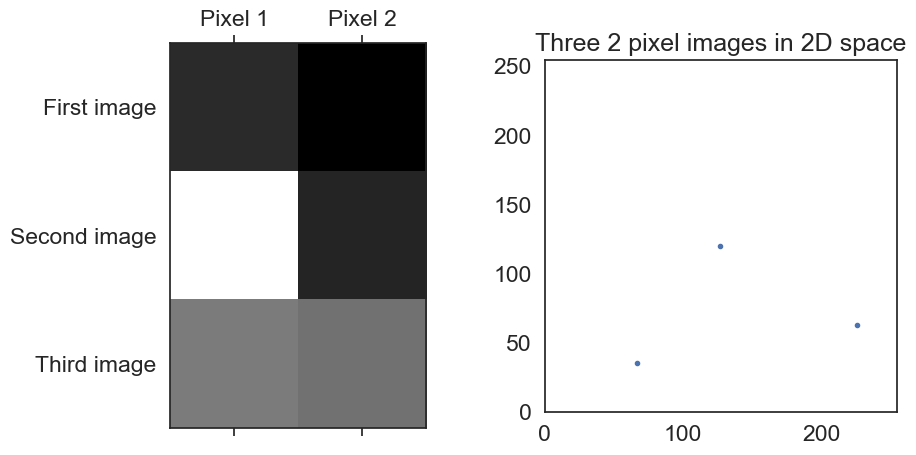

In [2]:
sns.set(font_scale = 1.5, style = "white")
seed = 72596
np.random.seed(seed)
im_array = np.rint((np.random.random((3,2))*255))

fig, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].matshow(im_array, cmap = 'gray')
ax[0].set_yticks([0,1, 2], ["First image", "Second image", "Third image"]);
ax[0].set_xticks([0, 1], ["Pixel 1", "Pixel 2"]);

ax[1].plot(im_array[:,0], im_array[:,1], ls = 'None', marker = '.')
ax[1].set_xlim(0, 255)
ax[1].set_ylim(0, 255)
ax[1].set_aspect(1) #create plot with equal aspect ratio
ax[1].set_title("Three 2 pixel images in 2D space")


Text(0.5, 1.0, '2D histogram = 50 bins')

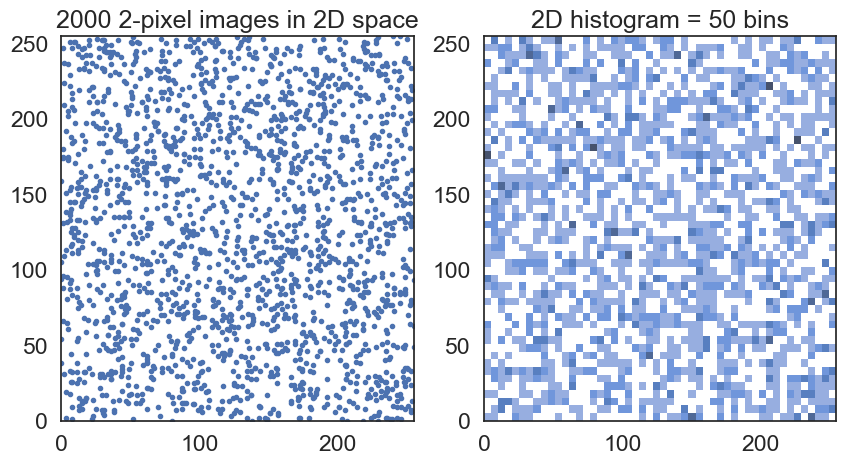

In [3]:
sns.set(font_scale = 1.5, style = "white")
seed = 72596

np.random.seed(seed)
im_array = np.rint((np.random.random((2000,2))*255))

fig, ax = plt.subplots(1,2, figsize = (10, 5))

ax[0].plot(im_array[:,0], im_array[:,1], ls = 'None', marker = '.')
ax[0].set_xlim(0, 255)
ax[0].set_ylim(0, 255) 
ax[0].set_title("2000 2-pixel images in 2D space")

sns.histplot(x = im_array[:,0], y = im_array[:,1], ax = ax[1], bins = 50)
ax[1].set_xlim(0, 255)
ax[1].set_ylim(0, 255)
ax[1].set_title("2D histogram = 50 bins")


* Given multiple images (still 2 pixels each), one can bin them in 2D, creating a probability distribution.

The example above is for random 2-pixel images created, so there are also random peaks. This may not be the case for real image data.

* This probability distribution can be used to generate new images. The generated images should follow the empirical distribution of pixel 1 and 2.

* Extending this to bigger images, the dimensionality of the problem increases (since each pixel is a dimension). Sampling in each dimension and laying them out together can recreate an image.

* GANs are hard to train because they sometimes do not learn the full probability distribution for a set of images and can only generate a subset (the example given is: a model trained on different animals sometimes only generate pictures of dogs).

2) Diffusion models and non-equilibrium dynamics

* Diffusion models are inspired by nonequilibrium thermodynamics. Nonequilibrium dynamics describes the probability distribution for a diffusion process. 

* In the post, the example used is a drop of ink diffusing in a container.

    - Initially, the blue ink is localized in an area. To calculate the probability of finding an ink molecule in the container, a probability distribution that models the initial state is needed. (This kind of distribution is hard to sample from.)
    
    - After diffusing through the water, the ink molecules becomes more uniformly distributed over the water. This is easier to express mathematically. 

3) Sohl-Dickstein et al.: Deep Unsupervised Learning using Nonequilibrium Thermodynamics [@nonequib2015]

* The algorithm for generative modeling is taught how to create noise from images. 

    - Given an image from the training set, noise is added to each pixel at every time step. Over time, the values of the pixels, approach the distribution of the noise. (Forward process)
    - Train the neural network on the noisy images to predict less noisy images from a previous step.
    
* This diffusion model was initially published by Jascha Sohl-Dickstein [@nonequib2015].

    - Main issues: images are worse than GAN generations
    
    - Process is slow

4) Song et al.: Generative Modeling by Estimating Gradients of the Data Distribution [@song2019]

* Instead of estimating the probability distribution of the data, they used the gradient of the distribution of the data

    - Perturb images in the training dataset with increasing levels of noise.
    - Train the neural network to predict the original image using gradients of the distribution.
    
* Song worked on this without knowing about Sohl-Dickstein's work.

5) Ho et al.: Denoising diffusion probabilistic models (DDPM) [@ho2020denoising]

* Updated Sohl-Dickstein's diffusion model with Song's ideas

* DDPMs matched or surpassed other generative models, including GANs (benchmark used: comparing distribution of generated images to training set)

6) Modern diffusion models

* More recent models all use a variation of DDPM.

* Other models include training on text to allow generation of images based on text.

7) Problems encountered

* Models are prone to bias based on their training datasets.

* Issue on ethics for scraped data (copyright, etc.)




## Related papers
Here, we look at key details in the papers mentioned in the overview post in Quanta Magazine. 

### Sohl-Dickstein et al.: Deep Unsupervised Learning using Nonequilibrium Thermodynamics [@nonequib2015]

#### Diffusion probabilistic models
In the paper, they presented an algorithm to model probability distributions that allows exact sampling and flexibility in model structure. The framework they developed uses a lot of ideas from physics (quasi-static processes and annealed importance sampling). 

The main goal is to define a diffusion process which converts any complex distribution into a simpler, tractable distribution, and then learn the reversal of the diffusion process. The training tries to minimize the model log-likelihood.


##### Forward diffusion process
The forward diffusion process converts a data distribution $q(\mathbf{x}^{(0)})$ gradually to an analytically tractable distribution $\pi(\mathbf{y})$ by applying a Markov diffusion kernel $T_{\pi}(\mathbf{y} \vert \mathbf{y'};\beta)$ for $\pi(\mathbf{y})$ where $\beta$ is the diffusion rate. Performing $T$ steps of diffusion starting from the data distribution is given as:

$$q(\mathbf{x}^{(0...T)})  = q(\mathbf{x}^{(0)})\prod^T_{t=1} q(\mathbf{x}^{(t)} \vert \mathbf{x}^{(t-1)})$$

* In the paper, they used 2D swiss roll data as an example. The forward diffusion process involves adding small amounts of Gaussian noise to the data sample until it becomes a Gaussian distribution.

##### Reverse trajectory
For very small $\beta$, reversing the diffusion process has a similar form to the forward diffusion process. (This corresponds to a quasi-static process.)

### Song et al.: Generative Modeling by Estimating Gradients of the Data Distribution [@song2019]
One of the main differences of this paper with Sohl-Dickenstein et al. is that instead of using the distribution for sampling, the gradient of the distribution (specifically, the gradient of the log-density) is used mainly. The neural network is trained with score matching to learn the gradient from the data.

The data is "perturbed with random Gaussian noise of different magnitudes"[@song2019] to ensure that sampling using Langevin dynamics does not fail. Their sampling strategy is  inspired by simulated annealing.

#### Noise-conditioned score network
To see what they mean here, let's look at the definition of terms:

* *Score* of a probability density $p(\mathbf{x})$ is the $\nabla_{\mathbf{x}} \mathrm {log}~p(\mathbf{x})$ (the score is just the gradient of the logarithm of the probability distribution).

* *Score network* $\mathbf{s_{\theta}}(\mathbf{x})$: a neural network parametrized by $\theta$. The network will be trained to approximate the score of $p_{data}(\mathbf{x})$
    
    - Score matching is used to train the score network to estimate $\nabla_{\mathbf{x}} \mathrm {log}~p(\mathbf{x})$ without training the model to estimate  $p_{data}(\mathbf{x})$
    
* Once the score network is trained such that $\mathbf{s_{\theta}}(\mathbf{x}) \approx \nabla_{\mathbf{x}} \mathrm {log}~p_{data}(\mathbf{x})$, samples are obtained with Langevin dynamics using $\mathbf{s_{\theta}}(\mathbf{x})$ to get approximate samples of the data distribution $p_{data}(\mathbf{x})$. (They call this score-based generative modeling)

Just using score-based generative modeling naively will result in issues, so they decided to perturb the data with noise tries to avoid issues with inaccurate score matching and to improve the mixing rate of Langevin dynamics. 

The data is perturbed using different levels of noise and a single score network is trained to simultaneously estimate scores at all noise levels.


### Ho et al.: Denoising diffusion probabilistic models (DDPM) [@ho2020denoising]

One of the key results of the paper is find the connection the first 2 papers [@nonequib2015, @song2019]: certain parametrization of the diffusion probabilistic model has an equivalence with denoising score matching at different noise levels with Langevin dynamics. The second one is to generate high quality samples using diffusion models. This paper uses Gaussian noise specifically (the original DPM paper also tried a binomial distribution).

In the original model: the choices made are: 1) $\beta_t$ of the forward process, 2) model architecture and parametrization of the Gaussian distribution for the reverse process. In this paper, they fixed $\beta_t$ to a constants that increase linearly with time. They also simplified the objective function $L$.






## Latent diffusion models and stable diffusion
Latent diffusion models (LDMs) were created with the goal of reducing the computational complexity of training and sampling without sacrificing the performance of diffusion models [@latent_diff]. Instead of working on the pixel space, latent diffusion models are "made to learn a space that is perceptually equivalent to the image space[^1], but offers reduced computational complexity" (which is called the latent space)[@latent_diff].

[Stable Diffusion (SD)](https://github.com/CompVis/stable-diffusion) is builds upon the work done by Rombach et al.[@latent_diff], and is a type of text-to-image LDM. SD is trained on  Unlike other text-to-image LDMs (like DALL-E 2), SD is open source and is trained on images from the [LAION](https://laion.ai), a non-profit that makes open-sourced AI models and datasets. Aside from using SD to generate images from text prompts, SD can be used for image modification (usually referred to as ```img2img```), using an image as an input and a prompt to guide the generation. 

### Testing image generation with Stable Diffusion
SD has an available [demo](https://huggingface.co/spaces/stabilityai/stable-diffusion) for testing out the outputs of SD 2.1. Here's an example of images generated with the prompt ```Paris in a rainy day```.

::: {#fig-paris layout-ncol=2}

![Four generations for ```Paris on a rainy day```](sd_rainy_paris.png){#fig-paris-1}

![Using ```umbrella``` as a negative prompt](sd_rainy_paris_negative.png){#fig-paris-2}

Generated images using [Stable Diffusion 2.1's demo on HuggingFace](https://huggingface.co/spaces/stabilityai/stable-diffusion) the text prompt ```Paris in a rainy day``` with and without negative prompts.
:::

In @fig-paris-1, we see that 2 of the images generated the Eiffel Tower, a famous landmark in Paris. Most of the images appear gray-ish and overcast, with some people in the scene walking with umbrellas. When ```umbrella``` is used in the negative prompts, there's no umbrellas in the scene, and interestingly, thescene appears more colorful (even with the ground looks flooded).

Since no seed is set, generations with the demo are still probabilistic, and testing to check how much of the generated images were affected by adding the negative prompt would require multiple generation of images. Based on this [blog post](https://stable-diffusion-art.com/how-to-use-negative-prompts/), it seems that negative prompts have more impact on newer SD models than the previous ones.

Regardless, the fact that it's now possible to start from noise and generate an image that matches the prompt is still mind-boggling.


[^1]: This sounds like what word embeddings are trying to do in LLMs, but for images.

## Real life problems concerning diffusion models

The rate at which AI image generation is developing is happening at a very rapid pace. With that being said, there are still issues that plague generative models in relation to the datasets the models are being trained on.


### Copyright

[LAION](https://laion.ai/faq/), the main source of the dataset is trained on, has a collection of links to scraped image data with alt-text as captions. This means that while the image may be publicly available through the Internet, the copyright to the images used may possibly be infringed. Aside from copyright infringement concerns, someone has [private medical record images of themselves](https://arstechnica.com/information-technology/2022/09/artist-finds-private-medical-record-photos-in-popular-ai-training-data-set/) in the LAION-5B database.

Currently, Stability AI is being sued by a [group of artists](https://www.theverge.com/2023/1/16/23557098/generative-ai-art-copyright-legal-lawsuit-stable-diffusion-midjourney-deviantart) and [Getty Images](https://edition.cnn.com/2023/01/17/tech/getty-images-stability-ai-lawsuit/index.html) for copyright infringement. While text-to-image generation will not replace artists creating art, artists with desired art styles (like [Greg Rutkowski](https://www.technologyreview.com/2022/09/16/1059598/this-artist-is-dominating-ai-generated-art-and-hes-not-happy-about-it/)) can have their works potentially flooded by AI generated images that they did not create. Currently, there is no way to know if your artwork has been included in the training of a diffusion model aside from checking if you have potentially been trained on.

Some recent developments allow ["disrupting style mimicry"](https://glaze.cs.uchicago.edu/what-is-glaze.html) done by diffusion models to protect artists. [Glaze](https://glaze.cs.uchicago.edu/faq.html) lets artists apply a "style cloaks" to their art before posting it online. The cloaks are image specific and lets the artist choose a target style. Fine-tuning the algorithm on cloaked images will result in generations that match the target style instead of the image's style. However, with the rapid pace of development in the field, it is unknown how long it will take before these kinds of protections can be circumvented.

### Biases in the dataset

Since diffusion models generate data that follow the distribution of the training set, any biases in the data can be reflected in generated data. The end of the Quanta Magazine article [@quantamag] talks about how an avatar generator is creating [sexualized images for women](https://www.technologyreview.com/2022/12/12/1064751/the-viral-ai-avatar-app-lensa-undressed-me-without-my-consent/) but not for men.

## Key takeaways

* Diffusion models take a lot of inspiration from nonequilibrium thermodynamics.

* The main goal of diffusion models is to create a sample that closely follows a modeled data distribution. A diffusion model achieves this by gradually adding noise to a distribution and learning how to remove this noise (or recreate a sample from the noise).

* Latent diffusion models performs the diffusion in the latent space (like an image embedding), which has a lower dimension than the pixel space.

* Many of the problems arising from the rapid advancement of diffusion models relate to the training data: the ethics behind the use of copyrighted data and possible harmful biases from the dataset.

## References

::: {#refs}
:::